In [1]:
import numpy as np
import matplotlib

from keras.datasets import mnist
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, Input
from keras.losses import categorical_crossentropy
from keras.models import Model, load_model
from keras.utils import to_categorical
import matplotlib
matplotlib.use('Agg')
from matplotlib import pyplot as plt
from PIL import Image

%matplotlib inline

Using TensorFlow backend.


In [2]:
# constants
IMG_HEIGHT, IMG_WIDTH = 28, 28
N_CLASSES = 10
BATCH_SIZE = 128
EPOCHS = 5
TRAINED_WEIGHTS_FILENAME = 'model_weights.hdf5'

# Keras

Keras is a library for defining and training neural networks. It lets you define network architectures declaritively, and gives you an API similar to scikit-learn for training neural networks.

First, let's see an example of a densly connected neural net trained on MNIST digits.

First, we'll prepare the data. Dense layers in Keras expect the input to be a vector, so we can't directly use the 2D matrix representation of the MNIST digits.

In [3]:
def prepare_flattened_data():
    
    (X_train, y_train), (X_val, y_val) = mnist.load_data()
    
    def _prep_data(X, y):
        # flatten the data for our dense net
        X = X.reshape(-1, IMG_HEIGHT * IMG_WIDTH)
        # Each pixel is represented by an 8 bit unsigned integer. 
        # Keras expects all inputs to be 32 bit floats
        X = X.astype(np.float32)
        # Squash pixel values to be between 0 and 1. 
        # This tends to help improve learning, but isn't strictly necessary.
        X /= 255
        y = to_categorical(y)
        return X, y
    
    X_train, y_train = _prep_data(X_train, y_train)
    X_val, y_val = _prep_data(X_val, y_val)
    return (X_train, y_train), (X_val, y_val)

In [4]:
(X_train, y_train), (X_val, y_val) = prepare_flattened_data()

We'll define a densly connected neural network with two hidden layers to get an idea of how models are defined in Keras. 

![title](../img/neural_net2.jpeg)

In [5]:
def setup_dense_model():
    """Set up a dense model.
    
    Note that this function doesn't do any actual model computation. It only 
    declares the structure of the neural network, which defines what kinds 
    of operations will be done by the model during inference."""
    
    # An input placeholder. This tells Keras the shape of the model input.
    flat_image = Input(shape=(IMG_HEIGHT * IMG_WIDTH,))
    
    # Defnies a dense layer with 512 units and a sigmoid activation function.
    # Note that layers are callable, and this layer takes the flat image placehodler as input.
    # Since it isn't the input "layer" or output layer, it is considered a "hidden layer".
    dense_1 = Dense(512, activation='sigmoid')(flat_image)
    
    # Another dense layer. This time, the input is the previous dense layer.
    dense_2 = Dense(512, activation='sigmoid')(dense_1)
    
    # A final dense layer that has as many units as there are classes we want to recognize.
    # The activation this time is a softmax function, which will convert the output to 
    # something that can be interpreted as a probability distribution.
    prediction = Dense(N_CLASSES, activation='softmax')(dense_2)
    
    # A Model is a directed acyclic graph from inputs to outputs. A Model object has an
    # API similar to scikit learn with `fit`, `predict`, and `evaluate` methods.
    model = Model(inputs=flat_image, outputs=prediction)
    return model

In [6]:
model = setup_dense_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________


# Exercise: When compiling, include accuracy as a metric

Refer to [Keras docs on metrics](https://keras.io/metrics/) to learn more.

In [7]:
# Models must be compiled. This step tells the model what objective function to minimize, and what 
# optimization algorithm to use. There are a ton of options available out of the box for objectives
# and optimizers, and you may also define your own.
model.compile(loss='categorical_crossentropy', optimizer='adam')

# The model is trained by sampling batches of examples and labels and peforming SGD.
# Each pass over the training data is referred to as an "epoch" and multiple epochs are 
# typically required for the model to converge.
train_history = model.fit(X_train, y_train,
                          batch_size=BATCH_SIZE, 
                          epochs=EPOCHS, 
                          validation_data=(X_val, y_val))

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 2s 31us/step - loss: 0.5004 - val_loss: 0.2422
Epoch 2/5
60000/60000 [==============================] - 1s 21us/step - loss: 0.2149 - val_loss: 0.1723
Epoch 3/5
60000/60000 [==============================] - 1s 22us/step - loss: 0.1558 - val_loss: 0.1484
Epoch 4/5
60000/60000 [==============================] - 1s 21us/step - loss: 0.1186 - val_loss: 0.1096
Epoch 5/5
60000/60000 [==============================] - 1s 21us/step - loss: 0.0929 - val_loss: 0.0930


In [8]:
# One way of better understanding our model is by observing the learning curves generated from the training and validation
# losses over time. The shape of these curves can tell is if the model is suffering from a bias or variance problem and 
# can provide clues for what to do next to improve performance.

def plot_train_history(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    epoch_labels = range(1, EPOCHS + 1)
    print epoch_labels
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_xticks(epoch_labels)
    ax.plot(epoch_labels, train_loss)
    ax.plot(epoch_labels, val_loss)
    ax.xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%d'))
    plt.show()

[1, 2, 3, 4, 5]


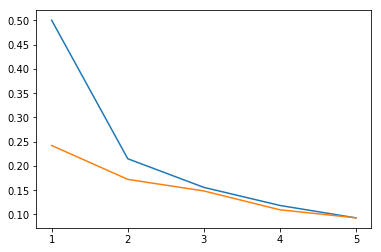

In [9]:
plot_train_history(train_history)

# Representation Learning

We didn't need to make many assumptions about our data for the dense model, and this tends to be true for neural networks in general. By using the hidden layers, we let the model learn its own representation of the input data that it then used to make the final prediction. This notion of representation learning is key to neural network performance. The network needs to identify meaningful information from the raw input in order to learn a suitable representation for each of the hidden layers, and these representations must contain suitable information for the final layer to make a correct prediction. 


# Convolutional Nets

One assumption that we can make to improve performance for vision tasks is that neighboring pixels are correlated, and that correlation is meaningful. This is the primary assumption that underlies convolutional neural networks. Let's dig in to the operations that are used within convnets.


## Convolutions

Convolutions are the workhorse of deep nets for computer vision. Each convolutional layers consist of a set of kernels (often called filters) that slide, or "convolve<sup>1</sup>", over the layer's input. At each position, the dot product between the kernel and the section of input is computed and becomes the output in that spatial position. The output of the dot product is maximal when the input best matches the kernel, signaling to the next layer that the pattern detected by the kernel is present at that location in the input. This exploits the fact that a pattern recognized anywhere in the image may still be relevant, regardless of where in the image it is. It also lets us do this pattern recognition with far fewer parameters than we would need if we used a fully connected neural network.

<sup>1</sup> In practice, most libraries actually implement a cross correlation rather than a true convolution.

![title](../img/convolution.gif)

There are typically tens or hundreds of kernels in each convolutional layer, leading to tens or hundreds of patterns that can be recognized by the layer anywhere in the image. These patterns tend to form a hierarchy. The layers closest to the input detect simple patterns such as edges and splashes of color. These low-level patterns are composed into more abstract patterns as signal moves through the network. By the end, the kernels are able to recognize abstract patterns that are useful for discriminating between classes. This representation can be understood as the features of the image, and then used in shallow neural nets (like in our example above) or in a linear model.

![title](../img/convnet_filters.png)



## Pooling

In a pooling layer, a patch of input is combined into a single output by taking the maximum value or averaging the values. The patches may have some overlap, or they may be completely distinct from one another.

![title](../img/max_pooling.png)

Pooling accomplishes two things. First, it contributes to learning translation invariance by combining information in adjacent areas of the input. Small translations in the input will be ignored by the pooling layer, and thus all subsequent layers. Second, it reduces the size of the intermediate representation, which reduces the memory footprint of all intermediate representations throughout the rest of the network by reducing the number of activations. This also helps combat overfitting.

Recent work from Geoff Hinton seeks to eliminate pooling by using a new kind of layer called a "capsule layer". This has demonstrated great performance on small tasks such as MNIST classification, but hasn't quite yet usurped pooling in practical applications. 

## Dropout

Dropout is a form of regularization that tends to work quite well in deep nets. Dropout layers randomly remove neurons in a layer, changing the internal activation structure of the network. Intuitively, this forces each neuron to contibute to the final prediction rather than relying on other neurons to do a good job. In theory, a network trained with dropout behaves like an ensemble of neural networks. 

![title](../img/dropout.png)

At inference time, the expected output of a neuron is computed using the actual output and the probability of keeping the neuron. This keeps the output of the network the same for each input. 

There's some fascinating new work that shows how sampling from a network trained with dropout lets you compute the confidence of the network's predictions. This provides a new way to understand how the network is behaving, and gives you more information to be used when making decisions about the model's output in downstream applications.

## Making it all work

Let's train a convnet on the same task as the dense model. 

First, we'll load and prepare the data for this model.

In [10]:
def prepare_2d_data():
    (X_train, y_train), (X_val, y_val) = mnist.load_data()

    def _prepare_data(X, y):        
        X = np.expand_dims(X, axis=3)  # add a color channel to each image
        X = X.astype(np.float32)  # convert from 8 bit ints to floats
        X /= 255  # squash pixel values to be between 0 and 1
        y = to_categorical(y, N_CLASSES)
        return X, y
    
    X_train, y_train = _prepare_data(X_train, y_train)
    X_val, y_val = _prepare_data(X_val, y_val)
    return (X_train, y_train), (X_val, y_val)

In [11]:
(X_train, y_train), (X_val, y_val) = prepare_2d_data()

We can now visualize our examples since we're training on actual 2D images (rather than flattened images)

In [12]:
def display_digit(img):
    """Undo all preprocessing to a single image and display it"""
    img = (img * 255).astype(np.uint8)  # unsquash and convert back to 8 bit ints
    img = np.squeeze(img, axis=2)  # remove color channel data to render grayscale image
    return Image.fromarray(img, mode='L')

In [13]:
# unsquash one image and view it
digit_idx = np.random.choice(np.arange(len(X_train)))
print 'label:', np.argmax(y_train[digit_idx])
display_digit(X_train[digit_idx])

label: 1


## Exercise: Follow the specification in this function's comments to create a convnet

Refer to the [Keras docs](https://keras.io/) to learn more about the different layer types.

In [14]:
def setup_convnet():
    """Set up a convolutional net for digit classification"""
    img = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1))
    conv1 = Conv2D(32, kernel_size=(3, 3), strides=1, activation='relu')(img)
    conv2 = Conv2D(64, kernel_size=(3, 3), strides=1, activation='relu')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(conv2)
    dropout1 = Dropout(0.25)(pool1)
    img_features = Flatten()(dropout1)
    dense1 = Dense(128, activation='relu')(img_features)
    dropout2 = Dropout(0.25)(dense1)
    digit = Dense(N_CLASSES, activation='softmax')(dropout2)
    model = Model(inputs=img, outputs=digit)
    return model

In [15]:
model = setup_convnet()
model.compile(loss=categorical_crossentropy, optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               1179776   
__________

Note that the layer with the most parameters is the dense layer right after the flatten layer. Convolution layers tend to be very efficient in the number of parameters. Most modern convnets are "fully convolutional", opting to use convolutions for all representation learning and only using a single dense layer to structure the predictions at the end of the network.

## Exercise: Using Keras callbacks, save a checkpoint of your model after every epoch

In [16]:
from keras.callbacks import ModelCheckpoint

train_history = model.fit(X_train, y_train,
                          batch_size=BATCH_SIZE, 
                          epochs=EPOCHS, 
                          callbacks=[ModelCheckpoint('weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss')],
                          validation_data=(X_val, y_val))

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 5s 90us/step - loss: 0.1909 - val_loss: 0.0458
Epoch 2/5
60000/60000 [==============================] - 5s 78us/step - loss: 0.0587 - val_loss: 0.0371
Epoch 3/5
60000/60000 [==============================] - 5s 77us/step - loss: 0.0417 - val_loss: 0.0318
Epoch 4/5
60000/60000 [==============================] - 5s 77us/step - loss: 0.0312 - val_loss: 0.0304
Epoch 5/5
60000/60000 [==============================] - 5s 77us/step - loss: 0.0274 - val_loss: 0.0322


[1, 2, 3, 4, 5]


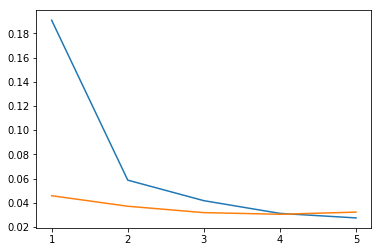

In [17]:
plot_train_history(train_history)

In [18]:
# sample an image + label to check the model qualitatively
sampled_id = np.random.choice(np.arange(len(X_val)))
img, label = X_val[sampled_id], y_val[sampled_id]
prediction = model.predict(np.expand_dims(img, axis=0))  # keras always expects a batch dimension, so we must expand
print 'label:', np.argmax(label), 'prediction:', np.argmax(prediction)
display_digit(img)

label: 6 prediction: 6


In [19]:
# save model for later use
model.save(TRAINED_WEIGHTS_FILENAME)

In [20]:
# load model later on to use it
model = load_model(TRAINED_WEIGHTS_FILENAME)